# Import Packages

In [1]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from skimage.morphology import erosion

%matplotlib inline

# Utility Functions

In [2]:
def fill_holes(img):
    im = img.copy().astype("uint8")
    h, w = img.shape[:2]
    im_mask = np.zeros((h + 2, w + 2), np.uint8)
    cv2.floodFill(im, im_mask, (0, 0), 255)
    im_inv = cv2.bitwise_not(im)
    
    return img | im_inv

def get_boundary(img, reps=5):
    inner = img.copy()
    for _ in range(reps):
        inner = erosion(inner)

    return img - inner

def filter_coords(tumor_mid_coords, spawn_coords, tol=0.6):

    result = []
    dist_list = []

    for x, y in spawn_coords:
        euclidean_distance = np.linalg.norm(np.array(tumor_mid_coords) - np.array([x, y]))
        result.append([x, y, euclidean_distance])
        dist_list.append(euclidean_distance)

    distance_min = min(dist_list)
    distance_diff = max(dist_list) - distance_min
    distance_threshold = distance_min + tol * distance_diff

    return list(map(lambda i: i[:-1], filter(lambda j: j[-1] > distance_threshold, result)))

# Define Variables

In [3]:
tumor_filepath = "../tumor.nii"
mask_filepath = "../tumor_mask.nii"

box_size = 50
threshold = 190 # capture skull mask
outer_erosion_loops = 50 # bigger the number thicker the boundary
inner_erosion_loops = 5 # bigger the number thicker the boundary
tumor_coords_tol = 0.6 # higher the number, new tumor will be further away
overlap_min = 0.4 # minimum overlapping of inner skull mask with newly spawned tumor
overlap_max = 0.5# maximum overlapping of inner skull mask with newly spawned tumor
dist_transform_mask_size = 5
dist_transform_scalar = 1.5

result_filepath = "result.png"

# Load Images 

In [4]:
tumor_arr = sitk.GetArrayFromImage(sitk.ReadImage(tumor_filepath))
mask_arr = sitk.GetArrayFromImage(sitk.ReadImage(mask_filepath))

print("Shape of Tumor Image: {}".format(tumor_arr.shape))
print("Shape of Mask Image: {}".format(mask_arr.shape))

Shape of Tumor Image: (22, 512, 512)
Shape of Mask Image: (22, 512, 512)


# Extract Slice of Interest

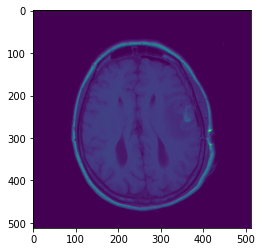

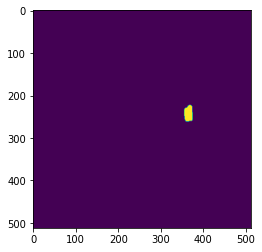

In [5]:
chosen_channel = [i for i in range(len(mask_arr)) if mask_arr[i, :, :].max()==1] # there is only one channel with mask annotated
assert len(chosen_channel) == 1
chosen_channel = chosen_channel[0]

tumor_arr = tumor_arr[chosen_channel, :, :]
mask_arr = mask_arr[chosen_channel, :, :]

for arr in [tumor_arr, mask_arr]:
    plt.figure()
    plt.imshow(arr)

# Extract Tumor From Image

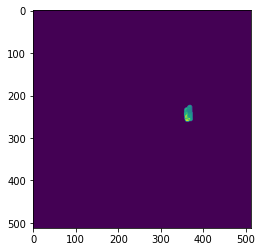

In [6]:
tumor_only = mask_arr * tumor_arr
plt.imshow(tumor_only)

# Extract and Rotate Box Containing Tumor

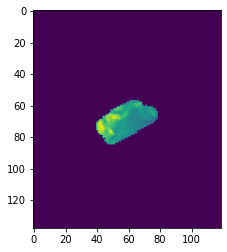

In [7]:
nonzero_px = np.argwhere(tumor_only!=0) # coordinates of nonzero pixels
x_max, y_max = nonzero_px.max(axis=0) # max coordinates of x and y
x_min, y_min = nonzero_px.min(axis=0) # min coordinates of x and y

x_min -= box_size
x_max += box_size

y_min -= box_size
y_max += box_size

tumor_box = tumor_only[x_min:x_max, y_min:y_max].copy()
tumor_box = np.array(Image.fromarray(tumor_box).rotate(np.random.randint(low=0, high=360))) # random rotation of tumor

plt.imshow(tumor_box)

# Thresholding and Fill Holes of Skull Mask

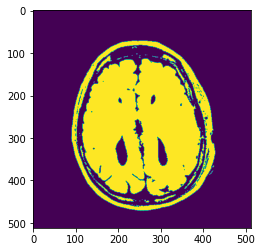

In [8]:
skull_mask = 1 * (tumor_arr > threshold)
plt.imshow(skull_mask)

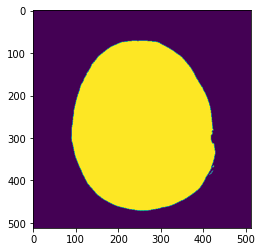

In [9]:
skull_mask = fill_holes(skull_mask)
plt.imshow(skull_mask)

# Get Outer Boundary Mask

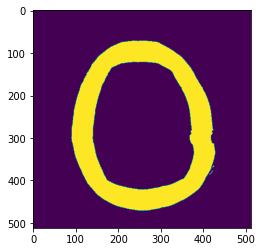

In [10]:
boundary_mask = get_boundary(skull_mask, outer_erosion_loops)
plt.imshow(boundary_mask)

# Get Inner Boundary Mask For Spawning New Tumor

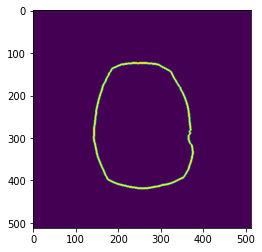

In [11]:
skull_mask[skull_mask > 1] = 1
boundary_mask[boundary_mask > 1] = 1

inner_boundary_mask = skull_mask - boundary_mask
boundary_mask = get_boundary(inner_boundary_mask, inner_erosion_loops)

boundary_mask[boundary_mask > 1] = 1

plt.imshow(boundary_mask)

# Get Coordinates for Spawning New Tumor

In [12]:
box_width = x_max - x_min
box_height = y_max - y_min

tumor_midpt = ((x_max + x_min) // 2, (y_max + y_min) // 2) # coordinates of tumor's midpt

spawn_coords = np.argwhere(boundary_mask != 0)
spawn_coords = filter_coords(tumor_midpt, spawn_coords, tol=tumor_coords_tol)

print(spawn_coords[:10])

[[122, 232], [122, 233], [122, 234], [122, 235], [122, 236], [122, 237], [122, 238], [122, 239], [122, 240], [122, 241]]


# Get Coordinates of Inner Skull Mask for Overlap Check

In [13]:
inner_coords = np.argwhere(inner_boundary_mask != 0)
inner_coords = set(map(lambda i: tuple(i), inner_coords))

print(list(inner_coords)[:10])

[(266, 351), (379, 314), (416, 288), (312, 241), (351, 304), (261, 216), (321, 357), (194, 237), (284, 367), (360, 157)]


# Spawn New Tumor

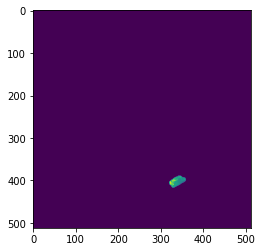

In [14]:
new_tumor = np.zeros_like(tumor_only)

while True:
    new_tumor = np.zeros_like(tumor_only)
    
    spawn_x_y = spawn_coords[np.random.randint(low=0, high=len(spawn_coords))]
    
    new_tumor[int(spawn_x_y[0] - box_width // 2):int(spawn_x_y[0] - box_width // 2) + tumor_box.shape[0],
             int(spawn_x_y[1] - box_height // 2):int(spawn_x_y[1] - box_height // 2) + tumor_box.shape[1]] = tumor_box
    
    new_tumor_coords = np.argwhere(new_tumor != 0)
    new_tumor_coords = set(map(lambda i: tuple(i), new_tumor_coords))
    
    if overlap_min < len(inner_coords & new_tumor_coords) / len(new_tumor_coords) < overlap_max:
        break

plt.imshow(new_tumor)

# Merge Original and New Tumor Images

In [15]:
new_mask = skull_mask * new_tumor
new_mask[new_mask != 0] = 1
new_mask = new_mask.astype("uint8")
dist_transform = cv2.distanceTransform(new_mask, cv2.DIST_L2, dist_transform_mask_size)
dist_transform /= dist_transform.max()

result = (1 - dist_transform) * tumor_arr + dist_transform * skull_mask * new_tumor * dist_transform_scalar
result = result.astype(int)

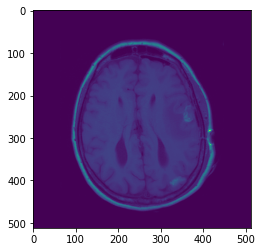

In [16]:
plt.imshow(result)